In [46]:
#import modules
import dask.array as da
from dask_ml.model_selection import train_test_split
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
from dask_ml.decomposition import IncrementalPCA as IPCA
from dask import delayed
import pandas as pd
import dask 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
dask.config.set({"dataframe.convert-string": False})

In [47]:
client = Client(n_workers=10, threads_per_worker=2, memory_limit='16GB')


/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34037 instead
  warnings.warn(


In [48]:
#import data matrix
fpath = '../saved_data/demeaned_data_matrix_week_5_cycling'
ddf = dd.read_csv(fpath, sep=',', header=0)   #, blocksize = 25e6

In [49]:
ddf.compute().shape

/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/home/zahmed/.conda/envs/sams/lib/python3.9/site

(419538, 1341)

In [50]:
#[x for x in ddf.isnull().sum().compute() if x !=0]

In [51]:
ddf = ddf.rename(columns={'Unnamed: 0':'temperature'})
ddf.columns

Index(['temperature', '613.1581342695605', '613.2882643171293',
       '613.4183935430451', '613.5485219466715', '613.6786495273719',
       '613.8087762845105', '613.9389022174508', '614.0690273255567',
       '614.1991516081921',
       ...
       '785.257345426425', '785.3858247710828', '785.5143024593286',
       '785.6427784905485', '785.7712528641274', '785.8997255794505',
       '786.0281966359041', '786.1566660328739', '786.2851337697449',
       '786.413599845903'],
      dtype='object', length=1341)

In [52]:
# define labels for x and y cols
col_list = ddf.columns
col_list[0]

# slice the ddf into X and y
X = ddf[col_list[1:]]
y = ddf[col_list[0]] 


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train_array = X_train.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)



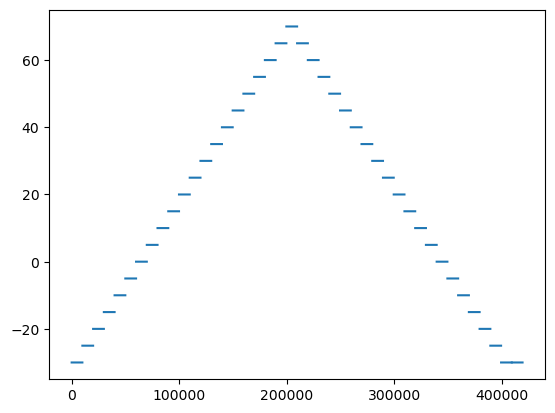

In [53]:
temp = y.compute().to_numpy()

plt.plot(temp)

In [54]:
n_comps= 10

ipca= IPCA(n_components=n_comps, batch_size=10000)


In [55]:
# Fit the PCA model
ipca.fit_transform(X_train_array, y_train.to_dask_array(lengths=True))

/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


dask.array<sum-aggregate, shape=(335706, 10), dtype=float64, chunksize=(2122, 10), chunktype=numpy.ndarray>

In [56]:
ipca.transform(X_test_array)

dask.array<sum-aggregate, shape=(83832, 10), dtype=float64, chunksize=(564, 10), chunktype=numpy.ndarray>

In [57]:
# Get explained variance ratio
explained_variance_ratio = ipca.explained_variance_ratio_

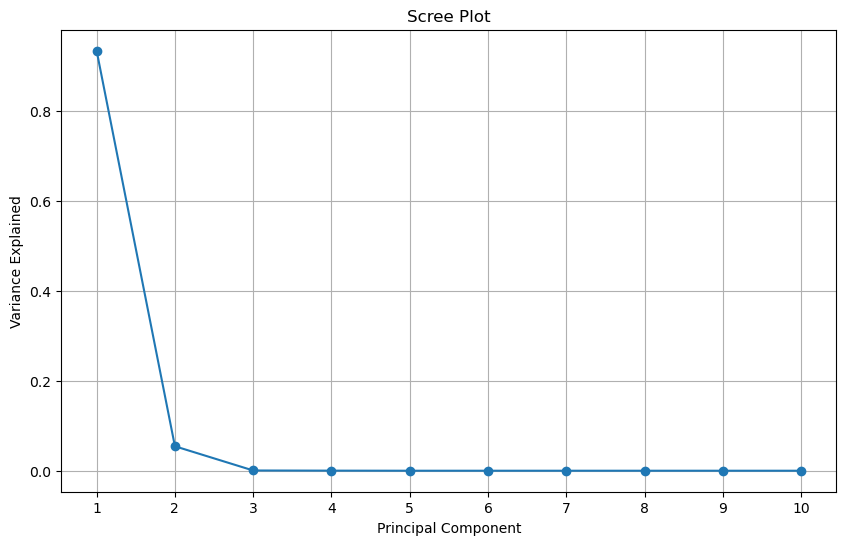

In [58]:
export_name = '../saved_data/sensor_2_week_1_first_cycle_screeplot.png'
# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid()
plt.savefig(export_name, dpi=700)
plt.show()

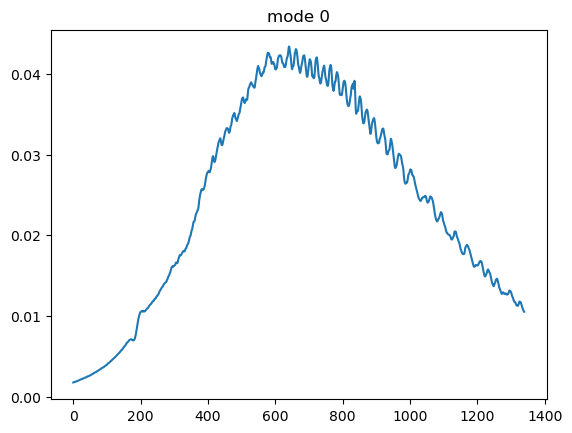

<Figure size 640x480 with 0 Axes>

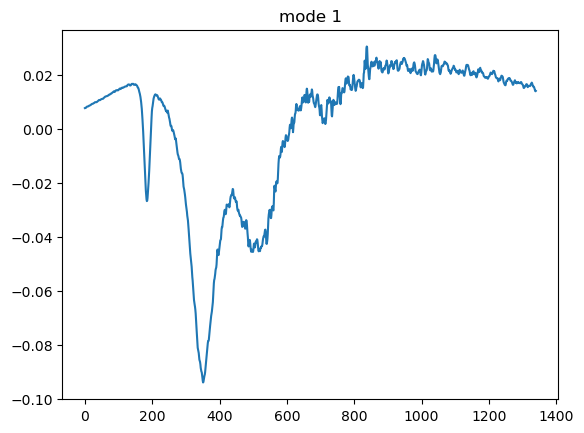

<Figure size 640x480 with 0 Axes>

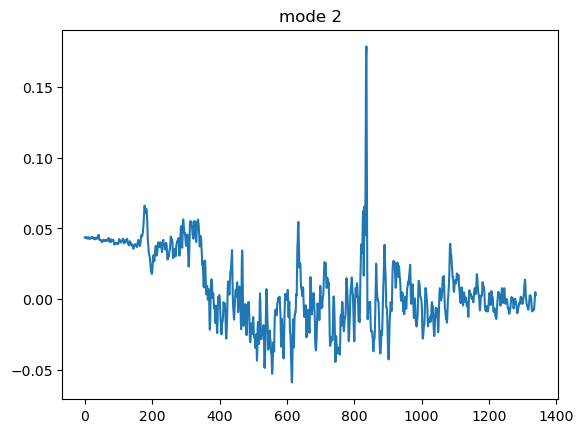

<Figure size 640x480 with 0 Axes>

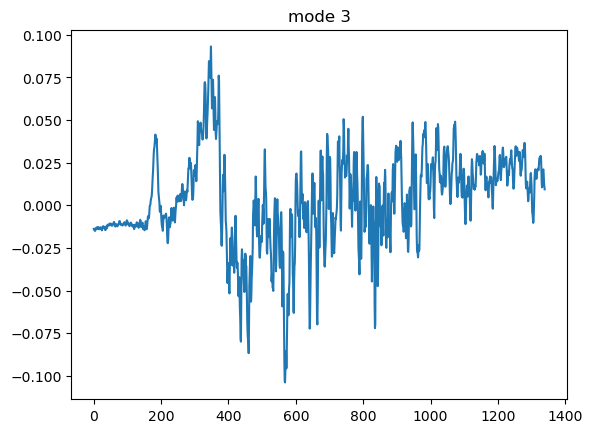

<Figure size 640x480 with 0 Axes>

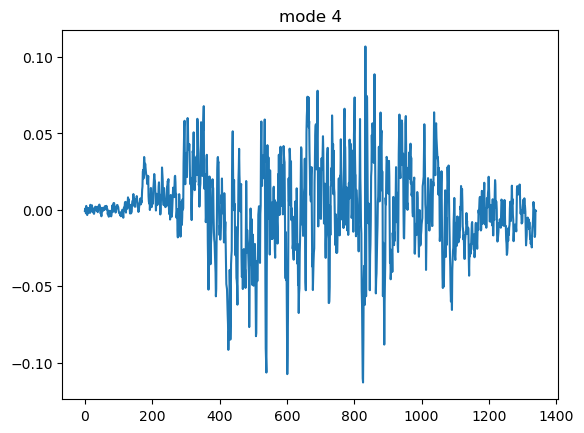

<Figure size 640x480 with 0 Axes>

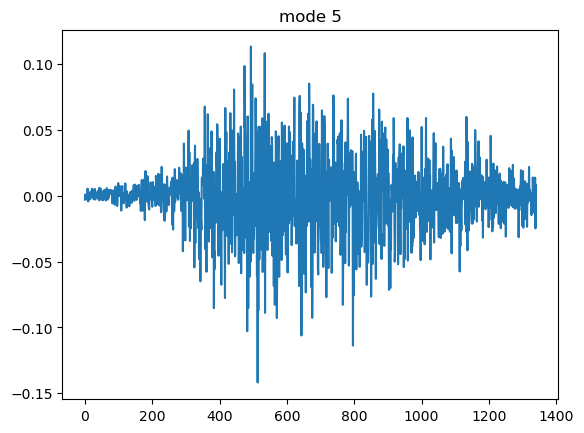

<Figure size 640x480 with 0 Axes>

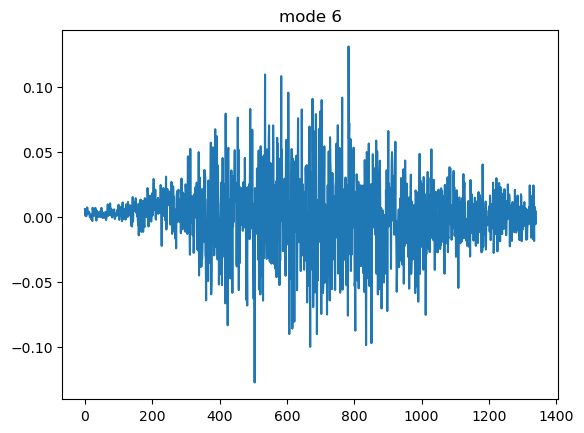

<Figure size 640x480 with 0 Axes>

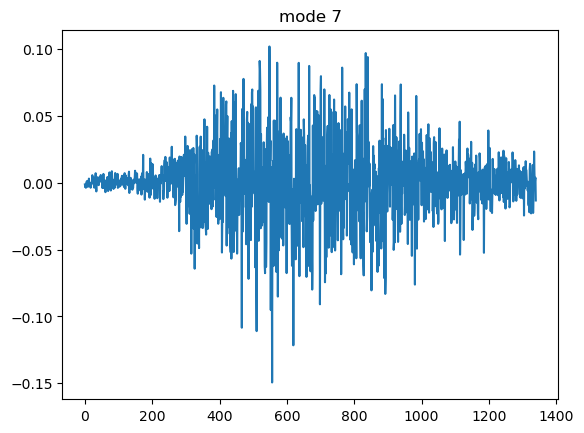

<Figure size 640x480 with 0 Axes>

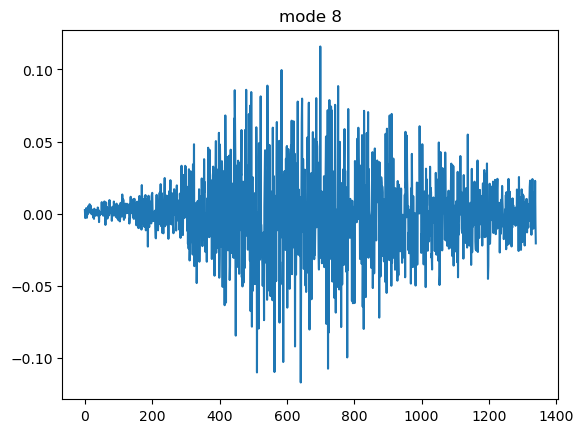

<Figure size 640x480 with 0 Axes>

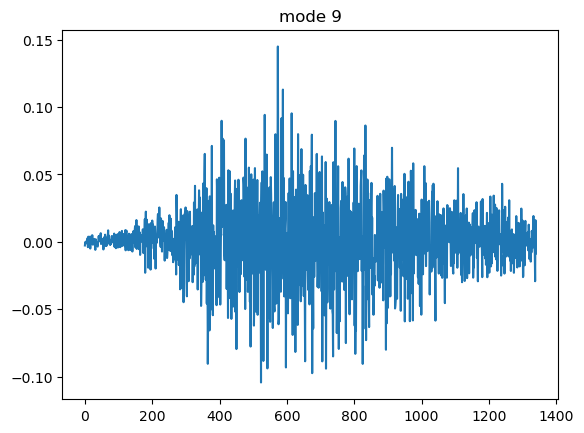

<Figure size 640x480 with 0 Axes>

In [73]:
for i in range(n_comps):
    plt.plot(ipca.components_.T[:,i]);
    plt.title('mode {}'.format(i));  plt.show()
    plt.savefig('../saved_data/ipca_mode{}_third_cycle_10000_batch.png'.format(i), dpi=700);plt.show()

In [60]:
ipca_export = '../saved_data/sensor_2_week_5_fifth_cycle_pca_modes.csv'

df_pca = pd.DataFrame(ipca.components_)

df_pca.to_csv(ipca_export)

In [61]:
loadings_train = (X_train_array@ipca.components_.T).compute()
loadings_test = (X_test_array@ipca.components_.T).compute()

In [62]:
loadings = (X.to_dask_array(lengths=True) @ ipca.components_.T).compute()

In [63]:
ipca_export_loadings = '../saved_data/sensor_2_week_5_fifth_cycle_pca_loadings.csv'

df_pca_loading = pd.DataFrame(loadings)

df_pca_loading.to_csv(ipca_export_loadings)

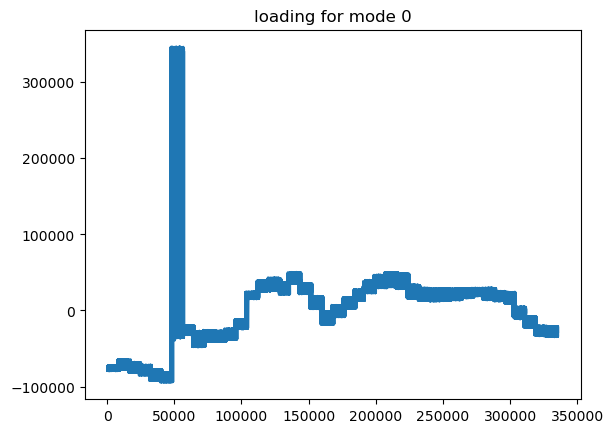

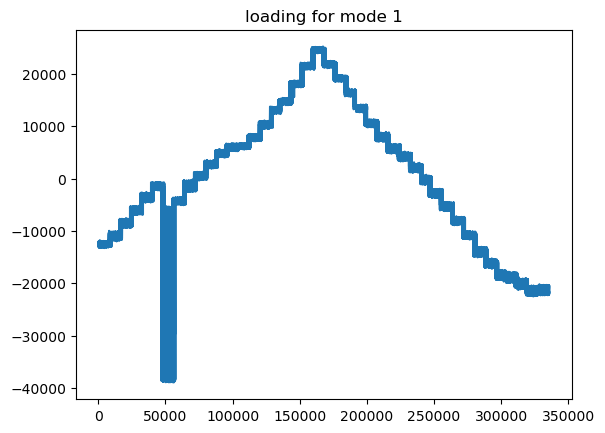

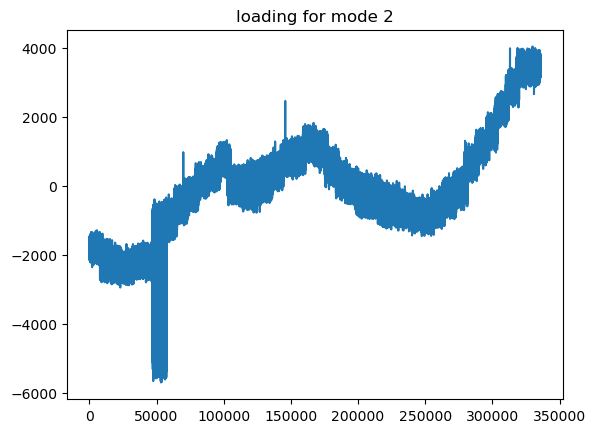

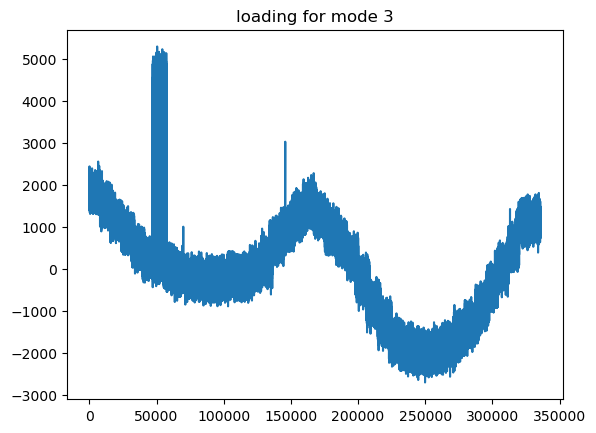

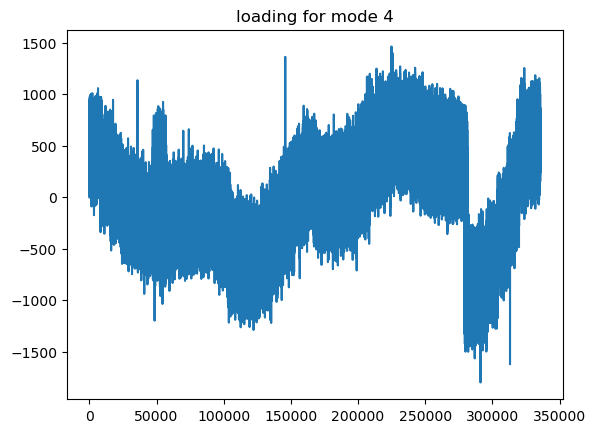

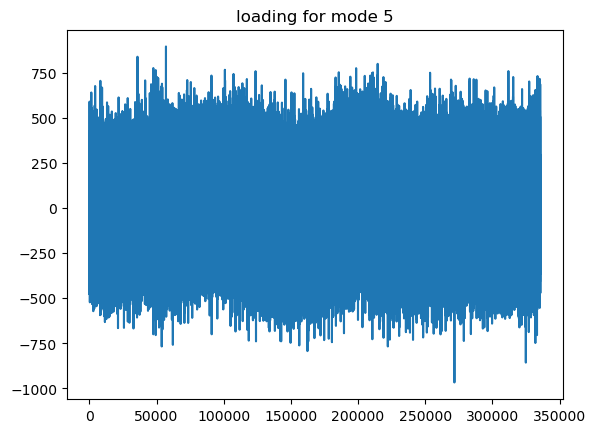

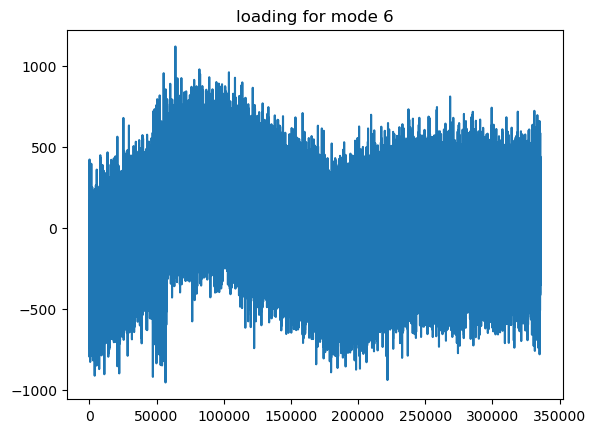

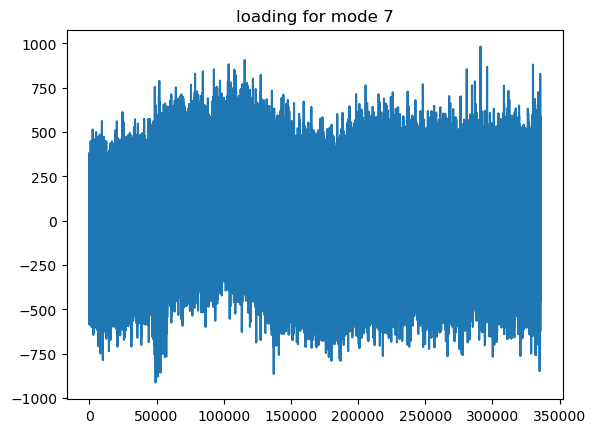

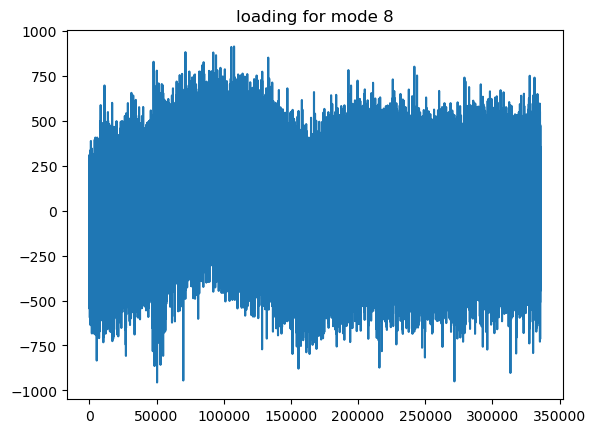

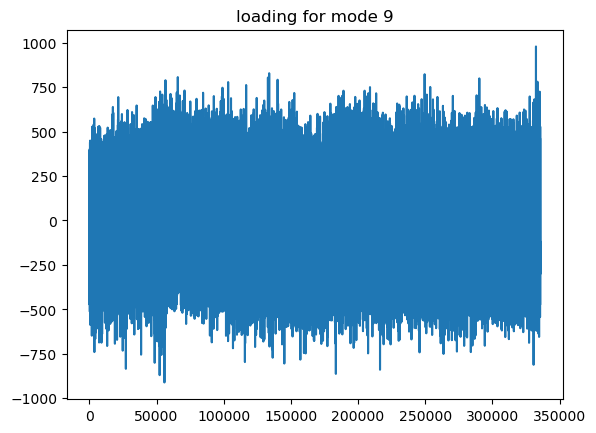

In [64]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
for i in range(n_comps):
    plt.plot(loadings_train[:, i])
    plt.title(f'loading for mode {i}')
    plt.savefig('../saved_data/sensor_2_week_5_eigenmode_{}_loading.png'.format(i))
    plt.show()



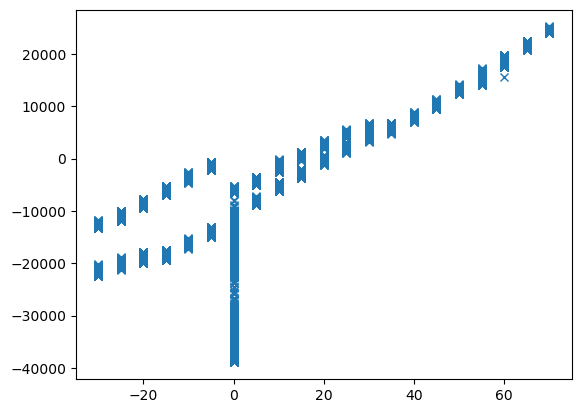

In [65]:
plt.plot(y_train.compute().to_numpy(), loadings_train[:, 1], 'x')

In [66]:
y_pred_test_comp = y_test.compute().to_numpy()

training error with 7 comps is 1.529203
testing error with 7 comps is 1.527910


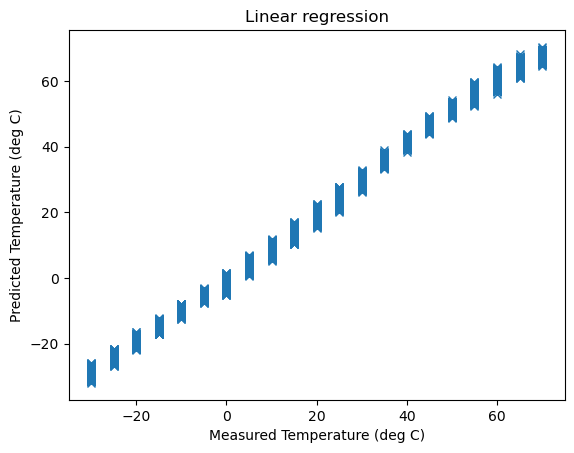

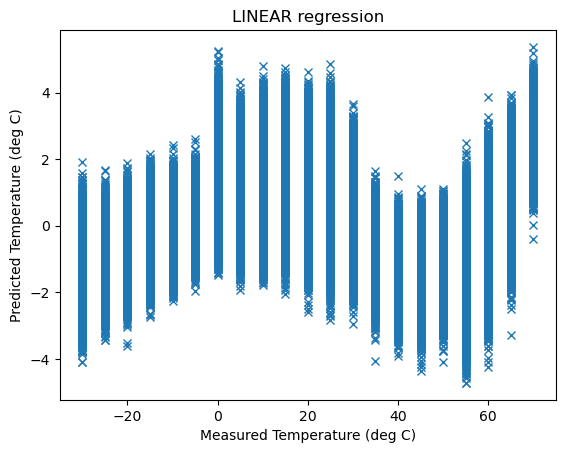

In [67]:

# =============================================================================
# test linear regression without reseting y index
# =============================================================================
lnr = LinearRegression()
x_t = loadings_train[:, 0:7]
lnr.fit(x_t, y_train)
y_pd = lnr.predict(x_t)
tr = np.sqrt(mean_squared_error(y_train, y_pd))
print(f'training error with 7 comps is {tr:3f}')
y_test_pd = lnr.predict(loadings_test[:, 0:7])
tr_t = np.sqrt(mean_squared_error(y_test, y_test_pd))
print(f'testing error with 7 comps is {tr_t:3f}')

#y_pred_test_comp = y_test_pd.compute()


plt.plot(y_pred_test_comp, y_test_pd, 'x')
plt.title('Linear regression')
plt.xlabel('Measured Temperature (deg C)')
plt.ylabel('Predicted Temperature (deg C)')
plt.savefig('../saved_data/sensor_2_week_1_first_cycle_LINEAR_testing.png', dpi = 700)
plt.show()

plt.plot(y_pred_test_comp, y_pred_test_comp-y_test_pd, 'x')
plt.title('LINEAR regression')
plt.xlabel('Measured Temperature (deg C)')
plt.ylabel('Predicted Temperature (deg C)')
plt.savefig('../saved_data/sensor_2_week_1_first_cycle_LINEAR_testing_residual.png', dpi = 700)
plt.show()

In [68]:
# GPLVM



In [69]:
client.close()